In [1]:
%matplotlib inline
import gym
import time
import random
import collections
import statistics
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from gym.envs.classic_control.cartpole import *
from pyglet.window import key
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,BatchNormalization,Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from IPython import display

In [2]:
# Build a network consisting of 2 fully connected layers and an output layer.
# Input is the state consisting of 4 float values, output is an action corresponding to left/right.
def build_model():
    inputs = keras.Input(shape=(4,))
    x = layers.Dense(32, activation='tanh')(inputs)
    x = layers.Dense(64, activation='tanh')(x)
    outputs = layers.Dense(2, activation="linear")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="dqn_model")
    optimizer = keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [3]:
class Matts_Agent:
    
    # Create model and target network.
    def __init__(self):
        self.model = build_model()
        self.target_network = build_model()
    
    # Use the CartPole environment to train an agent.
    def train_agent(self, num_episodes):
        
        # Training parameters.
        env = CartPoleEnv()
        gamma = 0.95
        epsilon = 0.97
        min_epsilon = 0.01
        decay_rate = (epsilon-min_epsilon)/(num_episodes-250) # Leave 250 episodes training at min_epsilon.
        memory = collections.deque(maxlen=100000)
        batch_size = 32
        max_reward = -1000000
        steps_to_update = 20
        losses = []
        episode_rewards = []
        
        for i in range(num_episodes):
            
            # Reset the environment.
            state = env.reset()
            episode_reward = 0 
            done = False

            while not done:
                env.render()
                
                # Determine if we are exploring or exploiting.
                exploring = np.random.choice([True,False], p=[epsilon, 1-epsilon])
                
                # Calcuate the q-values for the state using the model.
                action_q_values = self.model.predict([[state[0], state[1], state[2], state[3]]])
                
                # If we are exploring, move randomly. Otherwise select the best action as calculated by the model.
                if exploring:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(action_q_values)

                # Execute the move, catch the result and append the rewards.
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward
                
                # Append the experience to memory.
                memory.append((state, action, reward, next_state, done))
                
                # Move to the next state.
                state = next_state
            
            
            # Grab a random batch from memory.
            state_batch, q_batch = [], []
            mem_batch = random.sample(memory, min(len(memory), batch_size))
            
            # For each memory state, use the model to predict the q-values.
            for m_state, m_action, m_reward, m_next_state, m_done in mem_batch:
                m_q_values = self.model.predict([[m_state[0], m_state[1], m_state[2], m_state[3]]])
                if m_done:
                    # If the move resulted in game over, memory q-value equals the reward.
                    m_q_values[0][m_action] = m_reward
                else:  
                    # Otherwise use the Bellman equation and target network.
                    m_q_values[0][m_action] = m_reward + gamma * np.max(self.target_network.predict([[m_next_state[0], m_next_state[1], m_next_state[2], m_next_state[3]]])[0])
                
                # Append the memory state to the state batch and memory q-values to the q-batch.
                state_batch.append([m_state[0], m_state[1], m_state[2], m_state[3]])
                q_batch.append(m_q_values[0])
            
            # Update the network weights using the state and q-batch and append the losses to array.
            loss = self.model.train_on_batch(np.array(state_batch), np.array(q_batch))
            losses.append(loss)
            
            # Every 20 episodes update the target network.
            if i != 0 and i % 20 == 0:
                self.target_network.set_weights(self.model.get_weights())
            
            # If the episode is a high-score, save the model.
            if episode_reward >= max_reward:
                self.model.save("./dqn_exp_replay_tgtnetwork.h5")
                max_reward = episode_reward
            episode_rewards.append(episode_reward)
            print("Reward for episode", i,"is:", episode_reward, "({:.5f}".format(epsilon*100), "% steps are random) - training loss is", loss)
            
            # Decay epsilon until minimum value is reached.
            if epsilon > min_epsilon:    
                epsilon = epsilon - decay_rate

    # Use the model to generate a move for a given state.
    def make_move(self, state):
        action_q_values = self.model.predict([[state[0], state[1], state[2], state[3]]])
        return np.argmax(action_q_values)

In [4]:
# Train an agent for 2500 episodes
agent = Matts_Agent()
agent.train_agent(2500)

Reward for episode 0 is: 15.0 (97.00000 % steps are random) - training loss is 0.7385011911392212
Reward for episode 1 is: 22.0 (96.95733 % steps are random) - training loss is 0.670393705368042
Reward for episode 2 is: 24.0 (96.91467 % steps are random) - training loss is 0.6025536060333252
Reward for episode 3 is: 29.0 (96.87200 % steps are random) - training loss is 0.5804488658905029
Reward for episode 4 is: 26.0 (96.82933 % steps are random) - training loss is 0.5334835052490234
Reward for episode 5 is: 29.0 (96.78667 % steps are random) - training loss is 0.5322376489639282
Reward for episode 6 is: 12.0 (96.74400 % steps are random) - training loss is 0.5014230012893677
Reward for episode 7 is: 14.0 (96.70133 % steps are random) - training loss is 0.4412005543708801
Reward for episode 8 is: 64.0 (96.65867 % steps are random) - training loss is 0.4646090865135193
Reward for episode 9 is: 19.0 (96.61600 % steps are random) - training loss is 0.4821549952030182
Reward for episode 10

Reward for episode 83 is: 18.0 (93.45867 % steps are random) - training loss is 0.4117618203163147
Reward for episode 84 is: 11.0 (93.41600 % steps are random) - training loss is 0.32644063234329224
Reward for episode 85 is: 16.0 (93.37333 % steps are random) - training loss is 0.30042099952697754
Reward for episode 86 is: 16.0 (93.33067 % steps are random) - training loss is 0.24105465412139893
Reward for episode 87 is: 42.0 (93.28800 % steps are random) - training loss is 0.2614125907421112
Reward for episode 88 is: 19.0 (93.24533 % steps are random) - training loss is 0.1530129313468933
Reward for episode 89 is: 16.0 (93.20267 % steps are random) - training loss is 0.2085612416267395
Reward for episode 90 is: 24.0 (93.16000 % steps are random) - training loss is 0.11629286408424377
Reward for episode 91 is: 20.0 (93.11733 % steps are random) - training loss is 0.1217445433139801
Reward for episode 92 is: 16.0 (93.07467 % steps are random) - training loss is 0.1462550163269043
Reward

Reward for episode 165 is: 20.0 (89.96000 % steps are random) - training loss is 1.0540460348129272
Reward for episode 166 is: 28.0 (89.91733 % steps are random) - training loss is 0.6137737035751343
Reward for episode 167 is: 10.0 (89.87467 % steps are random) - training loss is 2.210481882095337
Reward for episode 168 is: 13.0 (89.83200 % steps are random) - training loss is 0.4296568036079407
Reward for episode 169 is: 23.0 (89.78933 % steps are random) - training loss is 0.5165009498596191
Reward for episode 170 is: 9.0 (89.74667 % steps are random) - training loss is 0.49487993121147156
Reward for episode 171 is: 20.0 (89.70400 % steps are random) - training loss is 0.04467945173382759
Reward for episode 172 is: 12.0 (89.66133 % steps are random) - training loss is 1.4121809005737305
Reward for episode 173 is: 16.0 (89.61867 % steps are random) - training loss is 0.5198517441749573
Reward for episode 174 is: 25.0 (89.57600 % steps are random) - training loss is 1.5475757122039795


Reward for episode 247 is: 46.0 (86.46133 % steps are random) - training loss is 0.29902786016464233
Reward for episode 248 is: 26.0 (86.41867 % steps are random) - training loss is 1.4752724170684814
Reward for episode 249 is: 9.0 (86.37600 % steps are random) - training loss is 0.8748689293861389
Reward for episode 250 is: 10.0 (86.33333 % steps are random) - training loss is 2.5042576789855957
Reward for episode 251 is: 23.0 (86.29067 % steps are random) - training loss is 1.1514312028884888
Reward for episode 252 is: 46.0 (86.24800 % steps are random) - training loss is 0.09914816170930862
Reward for episode 253 is: 32.0 (86.20533 % steps are random) - training loss is 0.09844496846199036
Reward for episode 254 is: 10.0 (86.16267 % steps are random) - training loss is 2.5712804794311523
Reward for episode 255 is: 55.0 (86.12000 % steps are random) - training loss is 0.056544456630945206
Reward for episode 256 is: 17.0 (86.07733 % steps are random) - training loss is 2.7707915306091

Reward for episode 329 is: 24.0 (82.96267 % steps are random) - training loss is 2.403341293334961
Reward for episode 330 is: 25.0 (82.92000 % steps are random) - training loss is 1.2403347492218018
Reward for episode 331 is: 13.0 (82.87733 % steps are random) - training loss is 6.667695999145508
Reward for episode 332 is: 18.0 (82.83467 % steps are random) - training loss is 8.960797309875488
Reward for episode 333 is: 26.0 (82.79200 % steps are random) - training loss is 1.1771985292434692
Reward for episode 334 is: 22.0 (82.74933 % steps are random) - training loss is 0.5351275205612183
Reward for episode 335 is: 12.0 (82.70667 % steps are random) - training loss is 0.19164174795150757
Reward for episode 336 is: 38.0 (82.66400 % steps are random) - training loss is 1.0990961790084839
Reward for episode 337 is: 37.0 (82.62133 % steps are random) - training loss is 1.2083426713943481
Reward for episode 338 is: 23.0 (82.57867 % steps are random) - training loss is 1.134525179862976
Rew

Reward for episode 412 is: 30.0 (79.42133 % steps are random) - training loss is 2.459670305252075
Reward for episode 413 is: 13.0 (79.37867 % steps are random) - training loss is 0.5495667457580566
Reward for episode 414 is: 37.0 (79.33600 % steps are random) - training loss is 1.3353724479675293
Reward for episode 415 is: 29.0 (79.29333 % steps are random) - training loss is 0.7572352886199951
Reward for episode 416 is: 21.0 (79.25067 % steps are random) - training loss is 2.183488607406616
Reward for episode 417 is: 22.0 (79.20800 % steps are random) - training loss is 1.4529201984405518
Reward for episode 418 is: 22.0 (79.16533 % steps are random) - training loss is 0.10665497183799744
Reward for episode 419 is: 53.0 (79.12267 % steps are random) - training loss is 1.9490065574645996
Reward for episode 420 is: 32.0 (79.08000 % steps are random) - training loss is 2.7695441246032715
Reward for episode 421 is: 20.0 (79.03733 % steps are random) - training loss is 0.705266535282135
Re

Reward for episode 495 is: 40.0 (75.88000 % steps are random) - training loss is 0.21130213141441345
Reward for episode 496 is: 78.0 (75.83733 % steps are random) - training loss is 0.7829448580741882
Reward for episode 497 is: 12.0 (75.79467 % steps are random) - training loss is 1.1314712762832642
Reward for episode 498 is: 16.0 (75.75200 % steps are random) - training loss is 0.1752088963985443
Reward for episode 499 is: 22.0 (75.70933 % steps are random) - training loss is 0.7340384721755981
Reward for episode 500 is: 17.0 (75.66667 % steps are random) - training loss is 0.718372106552124
Reward for episode 501 is: 81.0 (75.62400 % steps are random) - training loss is 2.502397060394287
Reward for episode 502 is: 33.0 (75.58133 % steps are random) - training loss is 0.3870548903942108
Reward for episode 503 is: 25.0 (75.53867 % steps are random) - training loss is 1.3479740619659424
Reward for episode 504 is: 30.0 (75.49600 % steps are random) - training loss is 0.6803854703903198
R

Reward for episode 577 is: 64.0 (72.38133 % steps are random) - training loss is 0.22475005686283112
Reward for episode 578 is: 111.0 (72.33867 % steps are random) - training loss is 2.4977188110351562
Reward for episode 579 is: 93.0 (72.29600 % steps are random) - training loss is 1.1098977327346802
Reward for episode 580 is: 48.0 (72.25333 % steps are random) - training loss is 0.9733715057373047
Reward for episode 581 is: 100.0 (72.21067 % steps are random) - training loss is 0.2923632562160492
Reward for episode 582 is: 20.0 (72.16800 % steps are random) - training loss is 5.268586158752441
Reward for episode 583 is: 42.0 (72.12533 % steps are random) - training loss is 2.006565809249878
Reward for episode 584 is: 20.0 (72.08267 % steps are random) - training loss is 0.5352189540863037
Reward for episode 585 is: 32.0 (72.04000 % steps are random) - training loss is 0.34118571877479553
Reward for episode 586 is: 26.0 (71.99733 % steps are random) - training loss is 2.838106155395508

Reward for episode 659 is: 32.0 (68.88267 % steps are random) - training loss is 4.692896842956543
Reward for episode 660 is: 9.0 (68.84000 % steps are random) - training loss is 0.3371042311191559
Reward for episode 661 is: 19.0 (68.79733 % steps are random) - training loss is 0.21455343067646027
Reward for episode 662 is: 12.0 (68.75467 % steps are random) - training loss is 1.919960618019104
Reward for episode 663 is: 22.0 (68.71200 % steps are random) - training loss is 0.22565053403377533
Reward for episode 664 is: 22.0 (68.66933 % steps are random) - training loss is 2.8141796588897705
Reward for episode 665 is: 38.0 (68.62667 % steps are random) - training loss is 0.1221013069152832
Reward for episode 666 is: 56.0 (68.58400 % steps are random) - training loss is 0.28209713101387024
Reward for episode 667 is: 55.0 (68.54133 % steps are random) - training loss is 3.689911365509033
Reward for episode 668 is: 24.0 (68.49867 % steps are random) - training loss is 1.0486538410186768
R

Reward for episode 741 is: 50.0 (65.38400 % steps are random) - training loss is 6.406796455383301
Reward for episode 742 is: 41.0 (65.34133 % steps are random) - training loss is 1.560732126235962
Reward for episode 743 is: 79.0 (65.29867 % steps are random) - training loss is 1.545785903930664
Reward for episode 744 is: 108.0 (65.25600 % steps are random) - training loss is 4.34229040145874
Reward for episode 745 is: 53.0 (65.21333 % steps are random) - training loss is 0.3790901303291321
Reward for episode 746 is: 96.0 (65.17067 % steps are random) - training loss is 1.4190294742584229
Reward for episode 747 is: 66.0 (65.12800 % steps are random) - training loss is 3.0992541313171387
Reward for episode 748 is: 61.0 (65.08533 % steps are random) - training loss is 3.005190134048462
Reward for episode 749 is: 33.0 (65.04267 % steps are random) - training loss is 2.7402119636535645
Reward for episode 750 is: 39.0 (65.00000 % steps are random) - training loss is 0.39150404930114746
Rewa

Reward for episode 823 is: 15.0 (61.88533 % steps are random) - training loss is 1.712952971458435
Reward for episode 824 is: 62.0 (61.84267 % steps are random) - training loss is 3.2033987045288086
Reward for episode 825 is: 33.0 (61.80000 % steps are random) - training loss is 1.449905276298523
Reward for episode 826 is: 75.0 (61.75733 % steps are random) - training loss is 0.4446483254432678
Reward for episode 827 is: 96.0 (61.71467 % steps are random) - training loss is 1.1675899028778076
Reward for episode 828 is: 22.0 (61.67200 % steps are random) - training loss is 0.20590215921401978
Reward for episode 829 is: 69.0 (61.62933 % steps are random) - training loss is 5.688332557678223
Reward for episode 830 is: 79.0 (61.58667 % steps are random) - training loss is 0.15560925006866455
Reward for episode 831 is: 36.0 (61.54400 % steps are random) - training loss is 0.32926586270332336
Reward for episode 832 is: 91.0 (61.50133 % steps are random) - training loss is 0.13512785732746124

Reward for episode 905 is: 120.0 (58.38667 % steps are random) - training loss is 0.24341613054275513
Reward for episode 906 is: 149.0 (58.34400 % steps are random) - training loss is 2.9633374214172363
Reward for episode 907 is: 38.0 (58.30133 % steps are random) - training loss is 0.9975497722625732
Reward for episode 908 is: 67.0 (58.25867 % steps are random) - training loss is 0.19606344401836395
Reward for episode 909 is: 140.0 (58.21600 % steps are random) - training loss is 0.13146796822547913
Reward for episode 910 is: 178.0 (58.17333 % steps are random) - training loss is 0.8251356482505798
Reward for episode 911 is: 15.0 (58.13067 % steps are random) - training loss is 2.1282846927642822
Reward for episode 912 is: 132.0 (58.08800 % steps are random) - training loss is 1.763224720954895
Reward for episode 913 is: 47.0 (58.04533 % steps are random) - training loss is 1.3815481662750244
Reward for episode 914 is: 93.0 (58.00267 % steps are random) - training loss is 6.7153282165

Reward for episode 987 is: 210.0 (54.88800 % steps are random) - training loss is 3.1886613368988037
Reward for episode 988 is: 202.0 (54.84533 % steps are random) - training loss is 1.2874261140823364
Reward for episode 989 is: 48.0 (54.80267 % steps are random) - training loss is 0.43016523122787476
Reward for episode 990 is: 212.0 (54.76000 % steps are random) - training loss is 0.6591053009033203
Reward for episode 991 is: 67.0 (54.71733 % steps are random) - training loss is 0.19524390995502472
Reward for episode 992 is: 56.0 (54.67467 % steps are random) - training loss is 0.3528648614883423
Reward for episode 993 is: 102.0 (54.63200 % steps are random) - training loss is 0.22742661833763123
Reward for episode 994 is: 81.0 (54.58933 % steps are random) - training loss is 3.1846365928649902
Reward for episode 995 is: 105.0 (54.54667 % steps are random) - training loss is 0.14446862041950226
Reward for episode 996 is: 115.0 (54.50400 % steps are random) - training loss is 2.7640347

Reward for episode 1068 is: 167.0 (51.43200 % steps are random) - training loss is 0.27299126982688904
Reward for episode 1069 is: 153.0 (51.38933 % steps are random) - training loss is 0.06389399617910385
Reward for episode 1070 is: 14.0 (51.34667 % steps are random) - training loss is 3.4423677921295166
Reward for episode 1071 is: 57.0 (51.30400 % steps are random) - training loss is 1.5587503910064697
Reward for episode 1072 is: 176.0 (51.26133 % steps are random) - training loss is 0.4023028314113617
Reward for episode 1073 is: 144.0 (51.21867 % steps are random) - training loss is 0.20875099301338196
Reward for episode 1074 is: 143.0 (51.17600 % steps are random) - training loss is 0.26559969782829285
Reward for episode 1075 is: 210.0 (51.13333 % steps are random) - training loss is 6.108704090118408
Reward for episode 1076 is: 174.0 (51.09067 % steps are random) - training loss is 2.162813425064087
Reward for episode 1077 is: 21.0 (51.04800 % steps are random) - training loss is 

Reward for episode 1149 is: 235.0 (47.97600 % steps are random) - training loss is 0.18769337236881256
Reward for episode 1150 is: 63.0 (47.93333 % steps are random) - training loss is 0.31261956691741943
Reward for episode 1151 is: 84.0 (47.89067 % steps are random) - training loss is 0.3221110701560974
Reward for episode 1152 is: 36.0 (47.84800 % steps are random) - training loss is 0.13433504104614258
Reward for episode 1153 is: 50.0 (47.80533 % steps are random) - training loss is 3.0343716144561768
Reward for episode 1154 is: 149.0 (47.76267 % steps are random) - training loss is 0.365530788898468
Reward for episode 1155 is: 162.0 (47.72000 % steps are random) - training loss is 2.768312692642212
Reward for episode 1156 is: 54.0 (47.67733 % steps are random) - training loss is 0.20173680782318115
Reward for episode 1157 is: 81.0 (47.63467 % steps are random) - training loss is 0.3180124759674072
Reward for episode 1158 is: 154.0 (47.59200 % steps are random) - training loss is 0.7

Reward for episode 1230 is: 170.0 (44.52000 % steps are random) - training loss is 0.07382316142320633
Reward for episode 1231 is: 192.0 (44.47733 % steps are random) - training loss is 0.08795749396085739
Reward for episode 1232 is: 191.0 (44.43467 % steps are random) - training loss is 2.5181589126586914
Reward for episode 1233 is: 213.0 (44.39200 % steps are random) - training loss is 0.09054232388734818
Reward for episode 1234 is: 201.0 (44.34933 % steps are random) - training loss is 0.11609433591365814
Reward for episode 1235 is: 161.0 (44.30667 % steps are random) - training loss is 4.753934383392334
Reward for episode 1236 is: 290.0 (44.26400 % steps are random) - training loss is 0.12633682787418365
Reward for episode 1237 is: 178.0 (44.22133 % steps are random) - training loss is 2.2525346279144287
Reward for episode 1238 is: 311.0 (44.17867 % steps are random) - training loss is 9.320390701293945
Reward for episode 1239 is: 234.0 (44.13600 % steps are random) - training loss

Reward for episode 1311 is: 369.0 (41.06400 % steps are random) - training loss is 0.3505019545555115
Reward for episode 1312 is: 133.0 (41.02133 % steps are random) - training loss is 0.11275775730609894
Reward for episode 1313 is: 187.0 (40.97867 % steps are random) - training loss is 4.799590587615967
Reward for episode 1314 is: 174.0 (40.93600 % steps are random) - training loss is 6.469320774078369
Reward for episode 1315 is: 144.0 (40.89333 % steps are random) - training loss is 1.4397214651107788
Reward for episode 1316 is: 296.0 (40.85067 % steps are random) - training loss is 0.20232543349266052
Reward for episode 1317 is: 253.0 (40.80800 % steps are random) - training loss is 1.908584713935852
Reward for episode 1318 is: 221.0 (40.76533 % steps are random) - training loss is 0.11152979731559753
Reward for episode 1319 is: 104.0 (40.72267 % steps are random) - training loss is 0.03877991437911987
Reward for episode 1320 is: 177.0 (40.68000 % steps are random) - training loss i

Reward for episode 1392 is: 130.0 (37.60800 % steps are random) - training loss is 0.30707859992980957
Reward for episode 1393 is: 175.0 (37.56533 % steps are random) - training loss is 6.283649921417236
Reward for episode 1394 is: 246.0 (37.52267 % steps are random) - training loss is 0.5712143182754517
Reward for episode 1395 is: 162.0 (37.48000 % steps are random) - training loss is 0.3129722476005554
Reward for episode 1396 is: 192.0 (37.43733 % steps are random) - training loss is 1.3674925565719604
Reward for episode 1397 is: 240.0 (37.39467 % steps are random) - training loss is 0.38390520215034485
Reward for episode 1398 is: 203.0 (37.35200 % steps are random) - training loss is 0.1050652489066124
Reward for episode 1399 is: 256.0 (37.30933 % steps are random) - training loss is 0.18639805912971497
Reward for episode 1400 is: 218.0 (37.26667 % steps are random) - training loss is 0.3145220875740051
Reward for episode 1401 is: 195.0 (37.22400 % steps are random) - training loss 

Reward for episode 1472 is: 376.0 (34.19467 % steps are random) - training loss is 2.239743232727051
Reward for episode 1473 is: 256.0 (34.15200 % steps are random) - training loss is 0.13513906300067902
Reward for episode 1474 is: 74.0 (34.10933 % steps are random) - training loss is 4.6983723640441895
Reward for episode 1475 is: 272.0 (34.06667 % steps are random) - training loss is 0.03329775854945183
Reward for episode 1476 is: 213.0 (34.02400 % steps are random) - training loss is 6.32607364654541
Reward for episode 1477 is: 210.0 (33.98133 % steps are random) - training loss is 0.09778569638729095
Reward for episode 1478 is: 240.0 (33.93867 % steps are random) - training loss is 0.12170757353305817
Reward for episode 1479 is: 314.0 (33.89600 % steps are random) - training loss is 0.05508816987276077
Reward for episode 1480 is: 289.0 (33.85333 % steps are random) - training loss is 4.117774486541748
Reward for episode 1481 is: 211.0 (33.81067 % steps are random) - training loss is

Reward for episode 1552 is: 203.0 (30.78133 % steps are random) - training loss is 0.06906589865684509
Reward for episode 1553 is: 296.0 (30.73867 % steps are random) - training loss is 0.07754172384738922
Reward for episode 1554 is: 247.0 (30.69600 % steps are random) - training loss is 0.1298309862613678
Reward for episode 1555 is: 306.0 (30.65333 % steps are random) - training loss is 0.037599943578243256
Reward for episode 1556 is: 223.0 (30.61067 % steps are random) - training loss is 1.5757395029067993
Reward for episode 1557 is: 285.0 (30.56800 % steps are random) - training loss is 0.08000074326992035
Reward for episode 1558 is: 379.0 (30.52533 % steps are random) - training loss is 0.08669443428516388
Reward for episode 1559 is: 200.0 (30.48267 % steps are random) - training loss is 0.027661139145493507
Reward for episode 1560 is: 134.0 (30.44000 % steps are random) - training loss is 0.10216169059276581
Reward for episode 1561 is: 75.0 (30.39733 % steps are random) - training

Reward for episode 1632 is: 268.0 (27.36800 % steps are random) - training loss is 0.2203945517539978
Reward for episode 1633 is: 254.0 (27.32533 % steps are random) - training loss is 0.16624316573143005
Reward for episode 1634 is: 273.0 (27.28267 % steps are random) - training loss is 0.10789138078689575
Reward for episode 1635 is: 257.0 (27.24000 % steps are random) - training loss is 0.13435183465480804
Reward for episode 1636 is: 243.0 (27.19733 % steps are random) - training loss is 0.08549028635025024
Reward for episode 1637 is: 237.0 (27.15467 % steps are random) - training loss is 0.0726548284292221
Reward for episode 1638 is: 239.0 (27.11200 % steps are random) - training loss is 0.09727876633405685
Reward for episode 1639 is: 328.0 (27.06933 % steps are random) - training loss is 6.512534141540527
Reward for episode 1640 is: 262.0 (27.02667 % steps are random) - training loss is 0.09617529809474945
Reward for episode 1641 is: 308.0 (26.98400 % steps are random) - training lo

Reward for episode 1712 is: 510.0 (23.95467 % steps are random) - training loss is 0.022380052134394646
Reward for episode 1713 is: 284.0 (23.91200 % steps are random) - training loss is 0.03998396545648575
Reward for episode 1714 is: 374.0 (23.86933 % steps are random) - training loss is 0.02795734629034996
Reward for episode 1715 is: 235.0 (23.82667 % steps are random) - training loss is 0.02001037448644638
Reward for episode 1716 is: 298.0 (23.78400 % steps are random) - training loss is 0.03644762188196182
Reward for episode 1717 is: 287.0 (23.74133 % steps are random) - training loss is 0.016985146328806877
Reward for episode 1718 is: 320.0 (23.69867 % steps are random) - training loss is 0.02505233883857727
Reward for episode 1719 is: 248.0 (23.65600 % steps are random) - training loss is 0.01924533024430275
Reward for episode 1720 is: 281.0 (23.61333 % steps are random) - training loss is 5.259341716766357
Reward for episode 1721 is: 402.0 (23.57067 % steps are random) - trainin

Reward for episode 1792 is: 485.0 (20.54133 % steps are random) - training loss is 0.019149918109178543
Reward for episode 1793 is: 322.0 (20.49867 % steps are random) - training loss is 0.012513047084212303
Reward for episode 1794 is: 310.0 (20.45600 % steps are random) - training loss is 0.023551370948553085
Reward for episode 1795 is: 210.0 (20.41333 % steps are random) - training loss is 4.747221946716309
Reward for episode 1796 is: 295.0 (20.37067 % steps are random) - training loss is 0.036081407219171524
Reward for episode 1797 is: 362.0 (20.32800 % steps are random) - training loss is 0.02935810200870037
Reward for episode 1798 is: 232.0 (20.28533 % steps are random) - training loss is 0.025084245949983597
Reward for episode 1799 is: 283.0 (20.24267 % steps are random) - training loss is 0.03938340023159981
Reward for episode 1800 is: 331.0 (20.20000 % steps are random) - training loss is 0.029410868883132935
Reward for episode 1801 is: 265.0 (20.15733 % steps are random) - tra

Reward for episode 1872 is: 378.0 (17.12800 % steps are random) - training loss is 0.05264948308467865
Reward for episode 1873 is: 261.0 (17.08533 % steps are random) - training loss is 0.08991030603647232
Reward for episode 1874 is: 560.0 (17.04267 % steps are random) - training loss is 0.13245147466659546
Reward for episode 1875 is: 327.0 (17.00000 % steps are random) - training loss is 0.13225555419921875
Reward for episode 1876 is: 421.0 (16.95733 % steps are random) - training loss is 2.7803547382354736
Reward for episode 1877 is: 298.0 (16.91467 % steps are random) - training loss is 0.14262063801288605
Reward for episode 1878 is: 254.0 (16.87200 % steps are random) - training loss is 0.09549811482429504
Reward for episode 1879 is: 191.0 (16.82933 % steps are random) - training loss is 0.10789282619953156
Reward for episode 1880 is: 269.0 (16.78667 % steps are random) - training loss is 0.09276892244815826
Reward for episode 1881 is: 254.0 (16.74400 % steps are random) - training

Reward for episode 1952 is: 255.0 (13.71467 % steps are random) - training loss is 0.10792706906795502
Reward for episode 1953 is: 243.0 (13.67200 % steps are random) - training loss is 0.03378349915146828
Reward for episode 1954 is: 198.0 (13.62933 % steps are random) - training loss is 0.022546034306287766
Reward for episode 1955 is: 240.0 (13.58667 % steps are random) - training loss is 0.024635717272758484
Reward for episode 1956 is: 292.0 (13.54400 % steps are random) - training loss is 2.087070941925049
Reward for episode 1957 is: 229.0 (13.50133 % steps are random) - training loss is 0.04651815444231033
Reward for episode 1958 is: 256.0 (13.45867 % steps are random) - training loss is 0.03487757220864296
Reward for episode 1959 is: 249.0 (13.41600 % steps are random) - training loss is 2.30920147895813
Reward for episode 1960 is: 367.0 (13.37333 % steps are random) - training loss is 0.04215472191572189
Reward for episode 1961 is: 218.0 (13.33067 % steps are random) - training l

Reward for episode 2032 is: 399.0 (10.30133 % steps are random) - training loss is 0.024405144155025482
Reward for episode 2033 is: 327.0 (10.25867 % steps are random) - training loss is 0.02783043682575226
Reward for episode 2034 is: 407.0 (10.21600 % steps are random) - training loss is 0.012338431552052498
Reward for episode 2035 is: 387.0 (10.17333 % steps are random) - training loss is 0.012599555775523186
Reward for episode 2036 is: 325.0 (10.13067 % steps are random) - training loss is 0.01089417189359665
Reward for episode 2037 is: 298.0 (10.08800 % steps are random) - training loss is 2.3391942977905273
Reward for episode 2038 is: 416.0 (10.04533 % steps are random) - training loss is 0.018676884472370148
Reward for episode 2039 is: 287.0 (10.00267 % steps are random) - training loss is 0.019131135195493698
Reward for episode 2040 is: 277.0 (9.96000 % steps are random) - training loss is 0.009857023134827614
Reward for episode 2041 is: 265.0 (9.91733 % steps are random) - trai

Reward for episode 2112 is: 218.0 (6.88800 % steps are random) - training loss is 0.03166075050830841
Reward for episode 2113 is: 259.0 (6.84533 % steps are random) - training loss is 0.010864634066820145
Reward for episode 2114 is: 279.0 (6.80267 % steps are random) - training loss is 0.011984164826571941
Reward for episode 2115 is: 496.0 (6.76000 % steps are random) - training loss is 0.015879377722740173
Reward for episode 2116 is: 247.0 (6.71733 % steps are random) - training loss is 0.011685056611895561
Reward for episode 2117 is: 298.0 (6.67467 % steps are random) - training loss is 0.011340580880641937
Reward for episode 2118 is: 404.0 (6.63200 % steps are random) - training loss is 0.010827193036675453
Reward for episode 2119 is: 288.0 (6.58933 % steps are random) - training loss is 0.009475813247263432
Reward for episode 2120 is: 513.0 (6.54667 % steps are random) - training loss is 0.011997291818261147
Reward for episode 2121 is: 499.0 (6.50400 % steps are random) - training 

Reward for episode 2192 is: 363.0 (3.47467 % steps are random) - training loss is 0.05302804708480835
Reward for episode 2193 is: 343.0 (3.43200 % steps are random) - training loss is 3.0609328746795654
Reward for episode 2194 is: 372.0 (3.38933 % steps are random) - training loss is 0.01951112039387226
Reward for episode 2195 is: 303.0 (3.34667 % steps are random) - training loss is 0.059657737612724304
Reward for episode 2196 is: 360.0 (3.30400 % steps are random) - training loss is 0.027602773159742355
Reward for episode 2197 is: 474.0 (3.26133 % steps are random) - training loss is 0.020904362201690674
Reward for episode 2198 is: 271.0 (3.21867 % steps are random) - training loss is 0.01818232238292694
Reward for episode 2199 is: 400.0 (3.17600 % steps are random) - training loss is 0.0942181795835495
Reward for episode 2200 is: 264.0 (3.13333 % steps are random) - training loss is 3.0174872875213623
Reward for episode 2201 is: 383.0 (3.09067 % steps are random) - training loss is 

Reward for episode 2272 is: 387.0 (1.00000 % steps are random) - training loss is 0.008937031961977482
Reward for episode 2273 is: 456.0 (1.00000 % steps are random) - training loss is 0.008105931803584099
Reward for episode 2274 is: 256.0 (1.00000 % steps are random) - training loss is 0.0056786322966217995
Reward for episode 2275 is: 525.0 (1.00000 % steps are random) - training loss is 0.007559945806860924
Reward for episode 2276 is: 344.0 (1.00000 % steps are random) - training loss is 0.0048280744813382626
Reward for episode 2277 is: 288.0 (1.00000 % steps are random) - training loss is 0.007958180271089077
Reward for episode 2278 is: 262.0 (1.00000 % steps are random) - training loss is 0.006046460010111332
Reward for episode 2279 is: 336.0 (1.00000 % steps are random) - training loss is 0.006440308876335621
Reward for episode 2280 is: 436.0 (1.00000 % steps are random) - training loss is 0.014977720566093922
Reward for episode 2281 is: 260.0 (1.00000 % steps are random) - traini

Reward for episode 2352 is: 259.0 (1.00000 % steps are random) - training loss is 0.009279151447117329
Reward for episode 2353 is: 225.0 (1.00000 % steps are random) - training loss is 1.8526610136032104
Reward for episode 2354 is: 432.0 (1.00000 % steps are random) - training loss is 0.009931778535246849
Reward for episode 2355 is: 325.0 (1.00000 % steps are random) - training loss is 1.6495871543884277
Reward for episode 2356 is: 248.0 (1.00000 % steps are random) - training loss is 0.017843086272478104
Reward for episode 2357 is: 438.0 (1.00000 % steps are random) - training loss is 0.03014897182583809
Reward for episode 2358 is: 251.0 (1.00000 % steps are random) - training loss is 0.04735498130321503
Reward for episode 2359 is: 569.0 (1.00000 % steps are random) - training loss is 0.028225550428032875
Reward for episode 2360 is: 460.0 (1.00000 % steps are random) - training loss is 0.03289555385708809
Reward for episode 2361 is: 264.0 (1.00000 % steps are random) - training loss i

Reward for episode 2433 is: 265.0 (1.00000 % steps are random) - training loss is 0.024448741227388382
Reward for episode 2434 is: 440.0 (1.00000 % steps are random) - training loss is 0.02044334076344967
Reward for episode 2435 is: 247.0 (1.00000 % steps are random) - training loss is 0.010987924411892891
Reward for episode 2436 is: 284.0 (1.00000 % steps are random) - training loss is 1.108730435371399
Reward for episode 2437 is: 352.0 (1.00000 % steps are random) - training loss is 0.020947840064764023
Reward for episode 2438 is: 494.0 (1.00000 % steps are random) - training loss is 0.04234904423356056
Reward for episode 2439 is: 237.0 (1.00000 % steps are random) - training loss is 0.008094366639852524
Reward for episode 2440 is: 321.0 (1.00000 % steps are random) - training loss is 0.01058639120310545
Reward for episode 2441 is: 330.0 (1.00000 % steps are random) - training loss is 0.004808682948350906
Reward for episode 2442 is: 465.0 (1.00000 % steps are random) - training loss 

Episode 1 | Score: 540.0 | 540 steps | 99.53s.
Episode 2 | Score: 324.0 | 324 steps | 59.71s.
Episode 3 | Score: 427.0 | 427 steps | 78.56s.
Episode 4 | Score: 469.0 | 469 steps | 86.38s.
Episode 5 | Score: 729.0 | 729 steps | 135.33s.
Episode 6 | Score: 367.0 | 367 steps | 68.55s.
Episode 7 | Score: 467.0 | 467 steps | 87.03s.
Episode 8 | Score: 260.0 | 260 steps | 48.53s.
Episode 9 | Score: 317.0 | 317 steps | 57.44s.
Episode 10 | Score: 1104.0 | 1104 steps | 194.34s.
Episode 11 | Score: 371.0 | 371 steps | 69.77s.
Episode 12 | Score: 255.0 | 255 steps | 46.48s.
Episode 13 | Score: 405.0 | 405 steps | 73.82s.
Episode 14 | Score: 397.0 | 397 steps | 74.77s.
Episode 15 | Score: 244.0 | 244 steps | 43.48s.
Episode 16 | Score: 466.0 | 466 steps | 89.64s.
Episode 17 | Score: 655.0 | 655 steps | 122.49s.
Episode 18 | Score: 369.0 | 369 steps | 69.59s.
Episode 19 | Score: 812.0 | 812 steps | 153.77s.
Episode 20 | Score: 348.0 | 348 steps | 63.97s.
Episode 21 | Score: 403.0 | 403 steps | 72.

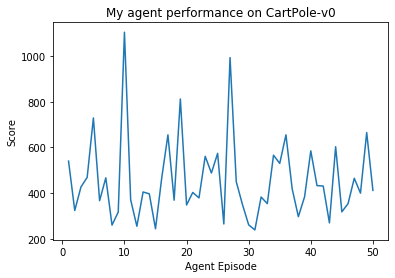

In [5]:
bool_do_not_quit = True 
scores = [] 
a = 0
env = CartPoleEnv()
number_of_trials = 50

def key_press(k, mod):
    global bool_do_not_quit, a, restart
    if k==0xff0d: restart = True
    if k==key.ESCAPE: bool_do_not_quit=False  # Added to Quit
    if k==key.Q: bool_do_not_quit=False  # Added to Quit
    if k==key.LEFT:  a = 0  # 0     Push cart to the left
    if k==key.RIGHT: a = 1  # 1     Push cart to the right

def run_cartPole_asAgent(agent):

    env.reset()
    env.render()
    env.viewer.window.on_key_press = key_press

    for _ in range(number_of_trials):
        state = env.reset()
        total_reward = 0.0
        steps = 0
        restart = False
        t1 = time.time()  # Trial timer
        while bool_do_not_quit:
            a = agent.make_move(state)
            state, reward, done, info = env.step(a)
            time.sleep(1/10)  # 10fps: Super slow for us poor little human!
            total_reward += reward
            steps += 1
            env.render()
            if done or restart:
                t1 = time.time()-t1
                scores.append(total_reward)
                print("Episode", len(scores), "| Score:", total_reward, '|', steps, "steps | %0.2fs."% t1)
                break
    env.close()

# Import trained model and assign to an agent.
agent = Matts_Agent()
agent.model = keras.models.load_model('best_dqn.h5')

run_cartPole_asAgent(agent)  # Run with agent input.

print("Average Score for", number_of_trials, "episodes is:",statistics.mean(scores))
# Plot your score
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title('My agent performance on CartPole-v0')
plt.ylabel('Score')
plt.xlabel('Agent Episode')
plt.show()